<a href="https://colab.research.google.com/github/lekhahanumaiah/Marvel-Level-2/blob/main/GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

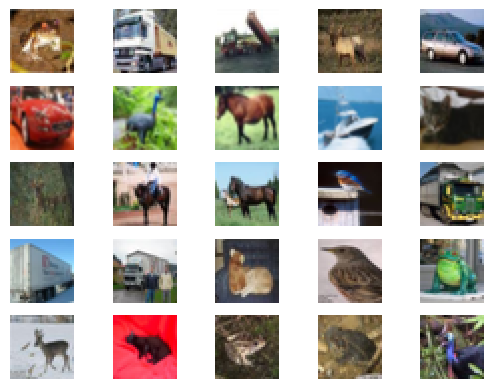

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Epoch>1, Batch 1/390, d1=0.674, d2=0.684, g=0.692
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Epoch>1, Batch 2/390, d1=0.679, d2=0.683, g=0.690
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Epoch>1, Batch 3/390, d1=0.682, d2=0.685, g=0.688
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Epoch>1, Batch 4/390, d1=0.682, d2=0.686, g=0.686
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Epoch>1, Batch 5/390, d1=0.684, d2=0.687, g=0.683
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Epoch>1, Batch 6/390, d1=0.685, d2=0.688, g=0.680
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Epoch>1, Batch 7/390, d1=0.686, d2=0.689, g=0.677
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Epoch>1, Batch 8/390, d1=0.688, d2=0.692, g=0.673
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Epoch>1, Batch 9/390, d1=0.690, d2=0.694, g=0.669
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Epoch>1, Batch 10/390, d1=0.693, d2=0.697, g=0.664
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Epoch>1, Batch 11/390, d1=0.696, d2=0.700, g=0.659
2/2 ━━━━━━━━━━━━━━━

In [ ]:
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Input
from keras.layers import LeakyReLU, Dropout
from matplotlib import pyplot as plt
import numpy as np

(trainX, trainy), (testX, testy) = load_data()

for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[i])
plt.show()

def define_discriminator(in_shape=(32,32,3)):
    input_layer = Input(shape=in_shape)
    x = Conv2D(128, (3,3), strides=(2,2), padding='same')(input_layer)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_generator(latent_dim):
    input_layer = Input(shape=(latent_dim,))
    n_nodes = 128 * 8 * 8
    x = Dense(n_nodes)(input_layer)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Reshape((8, 8, 128))(x)
    x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    output_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

def define_gan(generator, discriminator):
    discriminator.trainable = False
    input_layer = Input(shape=(100,))
    generated_image = generator(input_layer)
    validity = discriminator(generated_image)
    model = Model(inputs=input_layer, outputs=validity)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X

def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

def safe_loss(loss):
    return loss[0] if isinstance(loss, list) else loss

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # Train discriminator on real images
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real = safe_loss(d_model.train_on_batch(X_real, y_real))

            # Train discriminator on fake images
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake = safe_loss(d_model.train_on_batch(X_fake, y_fake))

            # Prepare latent points for GAN
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))

            # Train generator via GAN model
            g_loss = safe_loss(gan_model.train_on_batch(X_gan, y_gan))

            # Print losses
            print(f'Epoch>{i+1}, Batch {j+1}/{bat_per_epo}, d1={d_loss_real:.3f}, d2={d_loss_fake:.3f}, g={g_loss:.3f}')

    # Save the generator model
    g_model.save('cifar_generator_2epochs.h5')

latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

from keras.models import load_model

def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

model = load_model('cifar_generator_2epochs.h5')
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0
X = (X * 255).astype(np.uint8)
show_plot(X, 5)
